In [21]:
import ar 
import pandas as pd
import numpy as np

temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

temp_train, temp_test = temp.iloc[:-5000], temp.iloc[-5000:]

In [2]:
p = 8

model = ar.Autoregression(p)
model.fit(temp_train.values)
model.coefs

Success!


array([-0.10190282,  0.21370084,  0.09165088,  0.05325904, -0.04454372,
       -0.04078163, -0.34536534,  1.1704007 ])

In [22]:
def l2_improved(y_true, y_pred, indexes):
    if len(y_pred) != len(y_true):
        print("Lenghts are not the same!")
        return 0
    hour_vars = {0:     0.831691, 
                 3:     1.450059,
                 6:	    1.757970,
                 9:	    0.475864,
                 12:    0.629008,
                 15:	0.960935,
                 18:	1.110826,
                 21:	0.783646}
    s = 0
    n = len(y_true)
    for i in range(n):
        s += (y_true[i] - y_pred[i]) ** 2 * hour_vars[indexes[i]]
    return np.sqrt(s / n) 

In [3]:
import matplotlib.pyplot as plt

errors2d = []
for k in [4, 8, 16]:
    X_test = np.array([temp_test.values[i:i+k] for i in range(0, 2890-k, 1)])
    Y_test = np.array([temp_test.values[i+k] for i in range(0, 2890-k, 1)])

    print(f"Обучение модели для k={k}...")
    model = ar.Autoregression(k)
    model.fit(temp_train.values)
    errors = []

    for j in range(24):
        result = model.predict(X_test)
        errors.append(l2_improved(result, Y_test, [((x + j) % 8) * 3 for x in list(range(k, 2890))]))

        X_test = np.concatenate((X_test[:,1:], result.reshape(-1, 1)), axis=1)
        Y_test = np.array([temp_test.values[i+k] for i in range(j + 1, 2891+j-k, 1)])
    
    errors2d.append(errors)

Обучение модели для k=4...
Success!
Обучение модели для k=8...
Success!
Обучение модели для k=16...
Success!


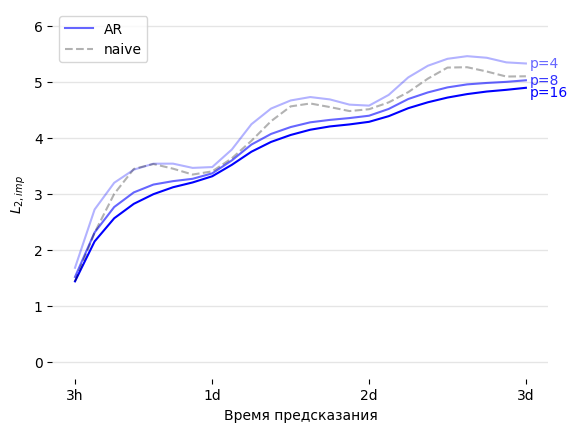

In [4]:
x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

errors_naive = [1.4397780182050635, 2.3083268163831785, 3.0005590439356684, 3.4464083445843094, 3.5343083326293887, 3.450806992828847, 3.3459484850706747, 3.402772319273203, 3.6361483346044765, 3.948508871997673, 4.298853263008481, 4.5630259197489895, 4.615051857565328, 4.55103620640407, 4.479715994589277, 4.512580692266964, 4.634599339409483, 4.817826161745919, 5.058715571267133, 5.256200029814936, 5.262736502585181, 5.18633236475787, 5.0960702480490525, 5.10072170495821]

plt.box(False)
for h in range(7):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, errors2d[0], color="blue", alpha=0.3)
plt.plot(x_values, errors2d[1], color="blue", alpha=0.6, label="AR")
plt.plot(x_values, errors2d[2], color="blue")
plt.plot(x_values, errors_naive, color="black", alpha=0.3, ls='--', label="naive")

plt.text(23.2, 5.26, "p=4", color='blue', alpha=0.6)
plt.text(23.2, 4.96, "p=8", color='blue', alpha=0.8)
plt.text(23.2, 4.74, "p=16", color='blue')

plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")

plt.xticks(x_values, names)
plt.xticks([0,7,15,23])

plt.legend()

plt.show()


p=4...
p=8...
p=16...


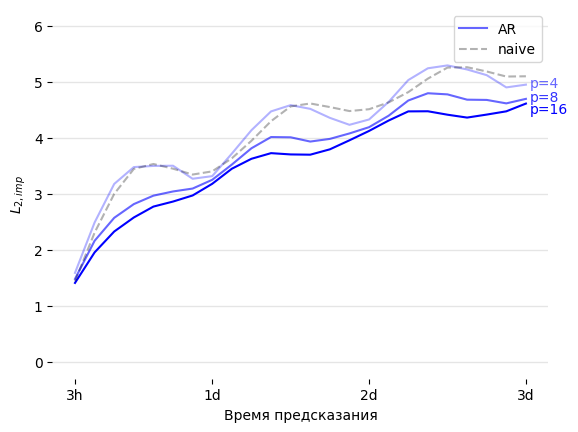

In [30]:
from arima import MyArma
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

errors = []
errors_naive = [1.4397780182050635, 2.3083268163831785, 3.0005590439356684, 3.4464083445843094, 3.5343083326293887, 3.450806992828847, 3.3459484850706747, 3.402772319273203, 3.6361483346044765, 3.948508871997673, 4.298853263008481, 4.5630259197489895, 4.615051857565328, 4.55103620640407, 4.479715994589277, 4.512580692266964, 4.634599339409483, 4.817826161745919, 5.058715571267133, 5.256200029814936, 5.262736502585181, 5.18633236475787, 5.0960702480490525, 5.10072170495821]


for p in [4, 8, 16]:
    print(f"p={p}...")
    model = MyArma(p, 0)
    model.fit(temp_train)

    results = np.array([model.predict(24)])

    for i in range(550):
        model.update(temp_test.iloc[9*i:9*(i+1)])
        results = np.append(results, [model.predict(24)], axis=0)

    maes = [l2_improved(results[:,j], temp_test.iloc[[9*i + j for i in range(551)]], temp_test.index[[9*i + j for i in range(551)]].hour) for j in range(24)]
    errors.append(maes)

x_values = list(range(24))
names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']

plt.box(False)
for h in range(7):
    plt.axhline(y=h, color='black', alpha=0.1, lw=1)

plt.plot(x_values, errors[0], color='blue', alpha=0.3)
plt.plot(x_values, errors[1], color='blue', alpha=0.6, label="AR")
plt.plot(x_values, errors[2], color='blue')
plt.plot(x_values, errors_naive, color="black", alpha=0.3, ls='--', label="naive")

plt.text(23.2, 4.9, "p=4", color='blue', alpha=0.6)
plt.text(23.2, 4.65, "p=8", color='blue', alpha=0.8)
plt.text(23.2, 4.45, "p=16", color='blue')

plt.legend()

plt.xticks(x_values, names)
plt.xticks([0,7,15,23])
plt.xlabel("Время предсказания")
plt.ylabel("$L_{2,imp}$")
plt.show()